In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words_full_length.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,24.457298,24.722471,uh,[ah],[-151.627188],[-151.36201499999999],0,0,0,s25,0,o,f,s2501b,16000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,24.722471,24.900012,it's,"[ih, t, s]","[-151.36201499999999, -151.292486, -151.236826]","[-151.292486, -151.236826, -151.184474]",1,1,1,s25,0,o,f,s2501b,16000,"[[182, 182, 183, 182, 181, 178, 174, 170, 169,..."
2,24.900012,25.121935,all,"[ao, l]","[-151.184474, -151.013765]","[-151.013765, -150.962551]",4,2,2,s25,0,o,f,s2501b,16000,"[[104, 110, 118, 124, 128, 128, 125, 129, 138,..."


In [9]:
len(syllable_df)

9735

In [10]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s25,s08,s24,s40,s15,s17,s13,s16
0,1456,1388,1105,1249,1779,1019,1343,396


In [11]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.word == i)] for i in tqdm(syllable_df.word.unique())}
    )
    .T.sort_values(by=0, ascending=False)
    .T
)

In [12]:
freq_words.T[:30].T

,i,and,the,that,a,it,to,of,uh,um,...,don't,yeah,for,think,mean,be,there,he,have,with
0,467,350,328,258,205,183,176,158,141,129,...,86,84,76,76,69,69,66,65,64,60


In [13]:
print(list(freq_words.columns[:200]))

['i', 'and', 'the', 'that', 'a', 'it', 'to', 'of', 'uh', 'um', 'in', 'like', 'was', 'yknow', 'but', 'so', 'they', "it's", 'just', 'you', "don't", 'yeah', 'for', 'think', 'mean', 'be', 'there', 'he', 'have', 'with', 'or', 'is', 'all', 'people', 'because', 'do', 'know', "they're", 'my', 'out', 'not', 'if', 'what', 'really', 'would', 'are', 'me', 'well', 'I', 'at', 'had', 'got', 'get', 'gonna', 'on', 'um-hum', "i'm", 'as', "that's", 'good', 'about', 'say', 'them', 'we', 'one', 'things', 'then', 'go', 'no', 'when', 'more', 'something', 'probably', 'were', 'from', 'up', "there's", 'going', 'even', 'time', "didn't", 'said', 'oh', 'some', 'could', 'been', 'years', 'lot', 'she', 'down', 'this', 'kind', 'right', 'can', 'see', "can't", 'thing', "he's", 'whatever', 'two', 'any', 'an', 'want', 'did', 'how', 'doing', 'around', 'where', 'their', 'his', 'anything', 'your', 'other', "you're", 'him', 'thought', 'better', 'work', 'now', 'here', 'year', 'still', 'place', 'everything', 'much', 'over', 'ki

### find words with high overlap in phones

In [14]:
word_phones_df = pd.DataFrame(
    {
        word: [
            syllable_df[syllable_df.word == word].iloc[0].phones,
            sum(syllable_df.word == word),
        ]
        for word in tqdm(syllable_df.word.unique())
    }
).T
word_phones_df.columns = ["phones", "count"]
word_phones_df[:3]

,phones,count
uh,[ah],141
it's,"[ih, t, s]",99
all,"[ao, l]",58


In [15]:
import numpy as np    
from scipy.spatial.distance import pdist, squareform
from nltk.metrics.distance import edit_distance

In [23]:
# my list of strings
strings = list(freq_words.columns[:200])

# prepare 2 dimensional array M x N (M entries (3) with N dimensions (1)) 
transformed_strings = np.array(strings).reshape(-1,1)

# calculate condensed distance matrix by wrapping the Levenshtein distance function
distance_matrix = pdist(transformed_strings,lambda x,y: edit_distance(x[0],y[0]))


In [25]:
# get square matrix
sqdist = squareform(distance_matrix)

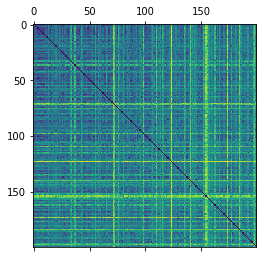

In [26]:
plt.matshow(sqdist)